gensim で分散表現を学習した後に、その重みを初期値として設定した Keras の Embedding層を取得する

In [2]:
import numpy as np
from gensim.models import word2vec
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import Sequential
from keras.layers import Embedding

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, LSTM
import MeCab

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\yoshihide.nakao\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


ImportError: No module named 'MeCab'

In [2]:
account_file = open("Data/勘定科目コード.csv",'r')
account_data = account_file.readlines()
account_file.close()

In [3]:
# 読み込んだデータをPythonリスト形式に変換して、2番目の勘定科目名と3番目の科目タイプを分離する
tagger = MeCab.Tagger('-F\s%f[6] -U\s%m -E\\n')

n = len(account_data)
account_list = []
account_target = []
for i in range(n):
    words = tagger.parse(account_data[i].split(',')[1])
    account_list.append(words.replace('\n', ''))
    account_target.append(int(account_data[i].split(',')[3]))

データが用意できたら、Word2vec のモデルを学習します。

In [4]:
w2v = word2vec.Word2Vec(min_count=1)
# 単語の登録
w2v.build_vocab([doc.split(' ') for doc in account_list])
# 学習
w2v.train(account_list, total_examples=w2v.corpus_count, epochs=w2v.iter)

1399

学習が終わったら、get_embedding_layerメソッドを用いて、Keras の Embedding層を取得します。

In [5]:
embedding_layer = w2v.wv.get_keras_embedding(train_embeddings=True)

In [6]:
MAX_SEQUENCE_LENGTH = 50

次に学習用データセットを準備します。 Keras の Tokenizer を用いて、単語をベクトル化する。
単語列を単語ID列に変換し、パディングしてしまいます。

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(account_list)
sequences = tokenizer.texts_to_sequences(account_list)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
Y = to_categorical(account_target)

In [8]:
N_train = 0.9
N_validation =0.2

# 訓練データとテストデータに分類
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=N_train)

//anaconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
# 訓練データをさらに訓練データと検証データに分類
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size = N_validation)

In [10]:
#モデル作成
# 入力層
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# 隠れ層
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(output_dim=128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)

# 出力層
preds = Dense(Y_train.shape[1], activation='softmax')(x)

model = Model(sequence_input, preds)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

//anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(recurrent_dropout=0.2, units=128, dropout=0.2)`
  import sys


In [11]:
# 過学習（オーバーフィッティング）防止の為、前のエポックのときと比べ誤差が増えたら学習を打ち切る
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
epochs = 100

hist = model.fit(X_train, Y_train, epochs=epochs,
          validation_data=(X_validation, Y_validation),
          callbacks=[early_stopping])

Train on 131 samples, validate on 33 samples
Epoch 1/100
131/131 [==============================] - 2s 18ms/step - loss: 1.5941 - acc: 0.4962 - val_loss: 1.5497 - val_acc: 0.4848
Epoch 2/100
131/131 [==============================] - 0s 2ms/step - loss: 1.4878 - acc: 0.5344 - val_loss: 1.3634 - val_acc: 0.4848
Epoch 3/100
131/131 [==============================] - 0s 2ms/step - loss: 1.3196 - acc: 0.5344 - val_loss: 1.3585 - val_acc: 0.4848
Epoch 4/100
131/131 [==============================] - 0s 2ms/step - loss: 1.3201 - acc: 0.5344 - val_loss: 1.3568 - val_acc: 0.4848
Epoch 5/100
131/131 [==============================] - 0s 2ms/step - loss: 1.2991 - acc: 0.5344 - val_loss: 1.3365 - val_acc: 0.4848
Epoch 6/100
131/131 [==============================] - 0s 2ms/step - loss: 1.2630 - acc: 0.5344 - val_loss: 1.3244 - val_acc: 0.4848
Epoch 7/100
131/131 [==============================] - 0s 2ms/step - loss: 1.2237 - acc: 0.5344 - val_loss: 1.3018 - val_acc: 0.4848
Epoch 8/100
131/131 [==

In [12]:
# 予測精度の評価
loss_and_metrics = model.evaluate(X_test, Y_test)
print(loss_and_metrics) # 1番目：誤差関数の値、2番目：予測精度

19/19 [==============================] - 0s 670us/step
[0.50952333211898804, 0.78947371244430542]


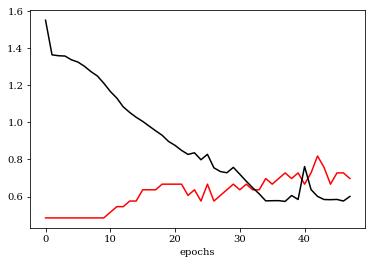

In [13]:
# 学習の進み具合を可視化

val_acc = hist.history['val_acc']
val_loss = hist.history['val_loss']

plt.rc('font', family='serif')
fig = plt.figure()
plt.plot(range(len(val_acc)), val_acc, label='val_acc', color='red')
plt.plot(range(len(val_loss)), val_loss, label='val_loss', color='black')

plt.xlabel('epochs')
plt.show()

In [14]:
# テスト用データを使用して予測する
test_size = 10
X_predict = np.argmax(model.predict(X_test[0:test_size]),axis=1)
print(X_predict)

[0 4 0 1 1 0 2 4 0 0]


In [15]:
# テスト用データの正解　0：資産　1：負債　2：純資産　3：収益　4：費用
print(np.argmax(Y_test[0:test_size],axis=1))

[0 4 0 1 1 0 2 4 0 1]


In [16]:
# 予測が正しかったか判定する
X_predict == np.argmax(Y_test[0:test_size],axis=1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True, False], dtype=bool)